<a href="https://colab.research.google.com/github/Fardad92/Ear_Detection/blob/main/EAROI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

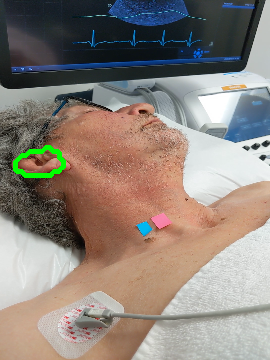

--(!) No captured frame -- Break!


In [2]:
!git clone https://github.com/Fardad92/Ear_Detection.git
import sys
sys.path.append('Ear_Detection/')
from models.resnet import rf_lw152
from utils.helpers import prepare_img

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import torch

from IPython.display import clear_output

cmap = np.load('Ear_Detection/utils/cmap.npy')


model = rf_lw152(2, imagenet=False)
device = next(model.parameters()).device
print(device)
model.eval()

cap = cv2.VideoCapture('input1.mp4')  #you can change this line for using imported video file
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fourcc = cv2.VideoWriter_fourcc(*'DIVX')

if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)
else:
    ret, frame1 = cap.read()

out = cv2.VideoWriter('output.avi', fourcc, 5.0, (270, 360))
i=0
while cap.isOpened():
    ret, frame1 = cap.read()
    if frame1 is None:
        print('--(!) No captured frame -- Break!')
        break
    if cv2.waitKey(10) == 27:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        break    


    frames = cv2.resize(frame1, (360, 270))
    framet = cv2.rotate(frames, cv2.ROTATE_90_CLOCKWISE)

    with torch.no_grad():
      img = cv2.cvtColor(framet, cv2.COLOR_BGR2RGB)
      orig_size = img.shape[:2][::-1]
      img_inp = torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]).float()

      segm = model(img_inp)
      segm = segm[0].data.cpu().numpy().argmax(axis=0).astype(np.uint8)
      segm = cv2.resize(segm, (orig_size), interpolation=cv2.INTER_NEAREST)
      segm = cmap[segm]

      gray = cv2.cvtColor(segm, cv2.COLOR_BGR2GRAY)
      edged = cv2.Canny(gray, 10, 20)
      contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      seg_con = cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
      print(100*(i/length))
      i += 1
      seg_con = cv2.cvtColor(seg_con, cv2.COLOR_RGB2BGR)
      clear_output(wait=True)
      cv2_imshow(seg_con)
      out.write(seg_con)


cap.release()
out.release()
cv2.destroyAllWindows()